In [62]:
base_dir = 'E:\\python projects\\face_identity'
num_classes = 2
image_size = 150

In [63]:
import os
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from keras import utils

def data_provider(data_path):
    images = []
    labels = []
    
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        for pic_name in os.listdir(class_path):
            pic_path = os.path.join(class_path, pic_name)
            if pic_path.endswith('.jpg'):
                #load_img直接载入图片，并可重新设置尺寸，返回的是图片格式。若用cv2.imread载入，返回的是数组格式。
                image = load_img(pic_path, target_size=(image_size, image_size))  
                image = img_to_array(image)  #将载入的图片转换为数组，才可进行下面的操作
                images.append(image)
                labels.append(class_name)
                
    images = np.array(images)   #此时的images是一个元素为数组的列表，需再转换一次，形成4维数组才能使用         
    labels = np.array([0 if label.endswith('bear') else 1 for label in labels])
    print('shape of total images: ',images.shape)
    print('shape of total labels: ',labels.shape)
    
    train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size=0.3, 
                                                                              random_state = random.randint(0,100))
    _, test_images, _, test_labels = train_test_split(images, labels, test_size=0.5, 
                                                                              random_state = random.randint(0,100))
    
    print('shape of train images: ',train_images.shape)
    print('shape of valid images: ',valid_images.shape)
    print('shape of test images: ',test_images.shape)
    #训练模型采用categorical_crossentropy作为损失函数，要求标签集必须采用one-hot编码形式
    train_labels = utils.to_categorical(train_labels, num_classes)                        
    valid_labels = utils.to_categorical(valid_labels, num_classes)            
    test_labels = utils.to_categorical(test_labels, num_classes)   
    
    return train_images, valid_images, test_images, train_labels, valid_labels, test_labels
    

In [64]:
from tensorflow.keras import layers
from tensorflow.keras import Model

#构建卷积神经网络模型
img_input = layers.Input(shape=(image_size,image_size,3))

x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.25)(x)

#最后加上全连接层、Dropout层和分类层
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

model = Model(img_input, output)

#查看网络结构
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 146, 146, 16)      2320      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 71, 71, 32)        4640      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 69, 69, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 34, 34, 32)        0         
__________

In [65]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['acc'])

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_images, valid_images, test_images, train_labels, valid_labels, test_labels = data_provider(base_dir)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
valid_test_datagen = ImageDataGenerator(rescale=1./255)
#flow_from_directory是从文件夹读取数据，flow是从内存读取。flow_from_directory可以减小内存占用，但如果需提前对数据做动态处理，只能用flow。
history = model.fit_generator(train_datagen.flow(train_images, train_labels, batch_size=20), steps_per_epoch=70, epochs=30, 
                              validation_data=(valid_test_datagen.flow(valid_images, valid_labels)), validation_steps=50, verbose=2)

shape of total images:  (2000, 150, 150, 3)
shape of total labels:  (2000,)
shape of train images:  (1400, 150, 150, 3)
shape of valid images:  (600, 150, 150, 3)
shape of test images:  (1000, 150, 150, 3)
Epoch 1/30
 - 153s - loss: 0.7224 - acc: 0.5129 - val_loss: 0.6966 - val_acc: 0.5076
Epoch 2/30
 - 148s - loss: 0.7068 - acc: 0.5293 - val_loss: 0.6933 - val_acc: 0.5057
Epoch 3/30
 - 147s - loss: 0.6914 - acc: 0.5507 - val_loss: 0.7073 - val_acc: 0.5013
Epoch 4/30
 - 147s - loss: 0.7131 - acc: 0.5821 - val_loss: 0.6671 - val_acc: 0.5821
Epoch 5/30
 - 145s - loss: 0.6861 - acc: 0.5836 - val_loss: 0.6499 - val_acc: 0.6155
Epoch 6/30
 - 145s - loss: 0.6711 - acc: 0.6036 - val_loss: 0.8732 - val_acc: 0.5170
Epoch 7/30
 - 146s - loss: 0.6716 - acc: 0.6079 - val_loss: 0.6415 - val_acc: 0.6162
Epoch 8/30
 - 147s - loss: 0.6692 - acc: 0.6143 - val_loss: 0.6423 - val_acc: 0.6237
Epoch 9/30
 - 145s - loss: 0.6659 - acc: 0.6236 - val_loss: 0.6327 - val_acc: 0.6439
Epoch 10/30
 - 145s - loss: 0

Text(0.5,1,'Training and validation loss')

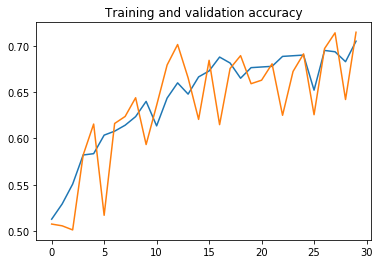

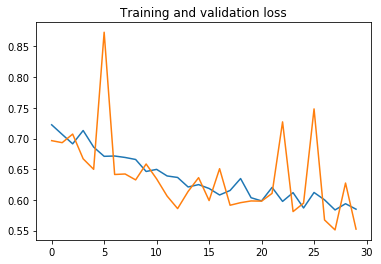

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc =history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [68]:
score = model.evaluate(test_images, test_labels, verbose=1)
print(score)

1000/1000 [==============================] - 24s 24ms/step
[7.456990957260132, 0.532]


In [69]:
model.save('E:\\python projects\\face_identity\\face_identity.h5')